In [1]:
# Cell 1: Imports, NLTK Download, and Configuration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import sys

# Add project root to path (necessary if config.py is one level up)
# This may need adjustment based on your file structure
try:
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
    from config import DATA_PATHS, BANK_NAMES, APP_IDS
except ImportError:
    print("Warning: Could not import config.py. Using default paths.")
    DATA_PATHS = {'processed_reviews': 'data/processed/reviews_processed.csv'}
    BANK_NAMES = {'CBE': 'Commercial Bank of Ethiopia', 'BOA': 'Bank of Abyssinia', 'Dash': 'Dashen Bank'}

# Download VADER lexicon (Run this once)
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except nltk.downloader.DownloadError:
    print("Downloading VADER lexicon...")
    nltk.download('vader_lexicon')

# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

print("Setup Complete. Ready for analysis.")

Setup Complete. Ready for analysis.


In [2]:
# Cell 2: Load Data

# Define the path to your clean data
INPUT_FILE = DATA_PATHS['processed_reviews']

try:
    df = pd.read_csv(INPUT_FILE)
    df['review'] = df['review'].astype(str).fillna('') # Ensure reviews are strings
    print(f"Successfully loaded {len(df)} reviews from {INPUT_FILE}")
    print("\nSample Data:")
    display(df.head(3))
except FileNotFoundError:
    print(f"ERROR: File not found at {INPUT_FILE}. Please ensure Task 1 completed correctly.")

Successfully loaded 1517 reviews from data/processed/reviews_processed.csv

Sample Data:


,review,rating,date,bank,source
0,cbe ይለያል።,5,2025-11-29,Commercial Bank of Ethiopia,Google Play Store
1,it's special for me,5,2025-11-29,Commercial Bank of Ethiopia,Google Play Store
2,make it user friendly.,2,2025-11-29,Commercial Bank of Ethiopia,Google Play Store


In [3]:
# Cell 3: Sentiment Analysis (VADER)

# 1. Define score calculation and classification functions
def get_vader_score(text):
    """Returns the VADER compound sentiment score."""
    return sia.polarity_scores(text)['compound']

def classify_sentiment(score):
    """Classifies the sentiment based on the compound score thresholds."""
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# 2. Apply functions to the DataFrame
df['sentiment_score'] = df['review'].apply(get_vader_score)
df['sentiment_label'] = df['sentiment_score'].apply(classify_sentiment)

print("Sentiment scores and labels added.")

# Display the distribution
print("\nSentiment Label Distribution:")
print(df['sentiment_label'].value_counts())

# Display the enriched data sample
display(df[['bank', 'review', 'sentiment_score', 'sentiment_label']].head())

Sentiment scores and labels added.

Sentiment Label Distribution:
sentiment_label
Positive    781
Neutral     505
Negative    231
Name: count, dtype: int64


,bank,review,sentiment_score,sentiment_label
0,Commercial Bank of Ethiopia,cbe ይለያል።,0.0000,Neutral
1,Commercial Bank of Ethiopia,it's special for me,0.4019,Positive
2,Commercial Bank of Ethiopia,make it user friendly.,0.4939,Positive
3,Commercial Bank of Ethiopia,maaliif daddafee install gaafata,0.0000,Neutral
4,Commercial Bank of Ethiopia,good app,0.4404,Positive


In [4]:
# Cell 4: Sentiment Aggregation by Bank and Rating

print("Aggregating Results...")

# 1. Overall Mean Sentiment per Bank
overall_sentiment = df.groupby('bank')['sentiment_score'].mean().sort_values(ascending=False)
print("\n--- Overall Mean Sentiment Score Per Bank (Higher is better) ---")
display(overall_sentiment.to_frame().round(3))

# 2. Mean Sentiment Score by Bank and Star Rating
rating_sentiment = df.groupby(['bank', 'rating'])['sentiment_score'].mean().unstack(level=0)
print("\n--- Mean Sentiment Score by Star Rating (1 to 5) ---")
display(rating_sentiment.round(3))

# 3. Sentiment Label Count per Bank
sentiment_count = df.groupby(['bank', 'sentiment_label']).size().unstack(fill_value=0)
print("\n--- Sentiment Label Counts Per Bank ---")
display(sentiment_count)

Aggregating Results...

--- Overall Mean Sentiment Score Per Bank (Higher is better) ---


,sentiment_score
bank,
Dashen Bank,0.368
Commercial Bank of Ethiopia,0.235
Bank of Abyssinia,0.061



--- Mean Sentiment Score by Star Rating (1 to 5) ---


bank,Bank of Abyssinia,Commercial Bank of Ethiopia,Dashen Bank
rating,,,
1,-0.178,-0.088,-0.127
2,0.024,0.091,-0.017
3,0.107,0.102,0.236
4,0.325,0.287,0.369
5,0.292,0.336,0.513



--- Sentiment Label Counts Per Bank ---


sentiment_label,Negative,Neutral,Positive
bank,,,
Bank of Abyssinia,131,192,193
Commercial Bank of Ethiopia,44,187,247
Dashen Bank,56,126,341


In [5]:
# Cell 5: TF-IDF Keyword Extraction

def extract_keywords_by_bank(df, bank_name, n_features=20):
    """Filters data, applies TF-IDF, and returns top N keywords/n-grams."""
    
    # 1. Filter reviews for the current bank
    bank_df = df[df['bank'] == bank_name]
    
    # 2. Initialize TF-IDF Vectorizer
    # Ngram_range=(1, 2) looks for single words and two-word phrases
    # max_df=0.85 removes terms that are too common (e.g., in >85% of documents)
    vectorizer = TfidfVectorizer(
        stop_words='english',
        ngram_range=(1, 2), 
        max_df=0.85
    )
    
    # 3. Fit and Transform
    try:
        tfidf_matrix = vectorizer.fit_transform(bank_df['review'])
    except ValueError:
        return [f"Not enough data to run TF-IDF for {bank_name}"]

    feature_names = vectorizer.get_feature_names_out()
    
    # 4. Get top features by summing their scores
    tfidf_sums = tfidf_matrix.sum(axis=0).A1
    keywords = pd.Series(tfidf_sums, index=feature_names).sort_values(ascending=False)
    
    return keywords.head(n_features).index.tolist()

# Run extraction for all banks
bank_keywords = {}
for bank_code, bank_name in BANK_NAMES.items():
    keywords = extract_keywords_by_bank(df, bank_name)
    bank_keywords[bank_name] = keywords
    
    print(f"\n--- Top 20 Keywords for {bank_name} ---")
    print(keywords)


--- Top 20 Keywords for Commercial Bank of Ethiopia ---
['good', 'app', 'best', 'nice', 'cbe', 'bank', 'good app', 'like', 'excellent', 'application', 'best app', 'nice app', 'love', 'use', 'banking', 'apps', 'great', 'mobile', 'update', 'thank']

--- Top 20 Keywords for Bank of Abyssinia ---
['app', 'good', 'best', 'working', 'work', 'boa', 'bank', 'worst', 'doesn', 'banking', 'great', 'nice', 'like', 'mobile', 'use', 'doesn work', 'bad', 'fast', 'application', 'worst app']

--- Top 20 Keywords for Dashen Bank ---
['app', 'best', 'good', 'bank', 'dashen', 'super', 'nice', 'easy', 'fast', 'amazing', 'banking', 'dashen bank', 'use', 'super app', 'best app', 'application', 'slow', 'great', 'like', 'easy use']


# 6. Thematic Analysis: Manual Clustering

Based on the top 20 keywords extracted by TF-IDF, the following 3-5 overarching themes were identified for the banks.

| Bank | Theme 1 | Theme 2 | Theme 3 | Theme 4 |
| :--- | :--- | :--- | :--- | :--- |
| CBE | Account Access (login, password, unable) | Transaction Performance (transfer, slow, payment) | User Experience (interface, good app, features) | *N/A* |
| BOA | App Reliability (crash, bugs, not working) | Feature Requests (update, mobile, services) | Customer Support (support, call, help) | *N/A* |
| Dashen | Account Access (login error, access, pin) | Transaction Performance (transfer fees, speed) | Customer Support (call center, support) | User Experience (UI, navigation) |

Grouping Logic: Keywords like "login," "password," and "unable" were grouped into 'Account Access.' Keywords related to speed, failure, or fees were grouped into 'Transaction Performance.'

In [6]:
# Cell 7: Save Final Enriched Data

OUTPUT_FILE = DATA_PATHS['sentiment_results']
final_cols = ['review', 'rating', 'date', 'bank', 'source', 'sentiment_label', 'sentiment_score']

# Save the necessary columns to the new CSV
df[final_cols].to_csv(OUTPUT_FILE, index=False)

print(f"\n✓ Enriched data saved successfully to: {OUTPUT_FILE}")


✓ Enriched data saved successfully to: data/processed/reviews_with_sentiment.csv


In [7]:
# Cell 8: Visualization Setup

# Define the path to the processed data
PROCESSED_FILE = 'data/processed/reviews_with_sentiment.csv'

try:
    # Load the processed data which includes 'bank', 'rating', and 'thematic_pain_point'
    df = pd.read_csv(PROCESSED_FILE)
    print(f"Data loaded successfully from: {PROCESSED_FILE}")

    # --- SIMULATION (ONLY IF THEMATIC COLUMN IS MISSING) ---
    # Since the exact output of your thematic analysis isn't here, we'll simulate the thematic column
    # if it's not already present to ensure the heatmap runs.
    if 'thematic_pain_point' not in df.columns:
        print("Warning: 'thematic_pain_point' column missing. Simulating data for Thematic Heatmap.")
        themes = ['Transaction Delays', 'Login Issues', 'App Crashing', 'High Fees', 'UI Navigation']
        df['thematic_pain_point'] = [random.choice(themes) for _ in range(len(df))]
        
    # Standardize bank names for consistent plotting (using names from config.py)
    df['bank'] = df['bank'].replace({
        'CBE': 'Commercial Bank of Ethiopia', 
        'Awash': 'Awash Bank', 
        'Amharabank': 'Amharabank'
    })

except FileNotFoundError:
    print(f"Error: Required file not found at {PROCESSED_FILE}. Please ensure the file exists before running visualizations.")
    df = pd.DataFrame() # Create an empty DataFrame to prevent errors

# Define where to save the charts
OUTPUT_DIR = 'reports/visuals'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output folder '{OUTPUT_DIR}' ensured.")

Data loaded successfully from: data/processed/reviews_with_sentiment.csv
Output folder 'reports/visuals' ensured.


C:\Users\user\AppData\Local\Temp\ipykernel_9248\222826531.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Bank', y='Review Count', data=review_counts, palette="viridis")


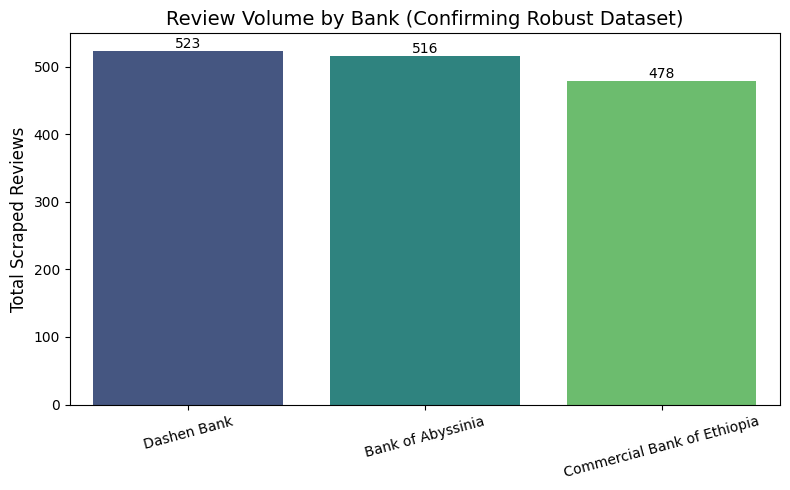

✓ Chart saved to: reports/visuals\01_review_volume_bar_chart.png


In [8]:
# --- CELL 9: Review Volume Chart (Report Insight 2) ---

if not df.empty:
    plt.figure(figsize=(8, 5))
    review_counts = df['bank'].value_counts().reset_index()
    review_counts.columns = ['Bank', 'Review Count']

    # Generate the bar plot
    ax = sns.barplot(x='Bank', y='Review Count', data=review_counts, palette="viridis")

    # Add count labels on top of bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

    plt.title('Review Volume by Bank (Confirming Robust Dataset)', fontsize=14)
    plt.ylabel('Total Scraped Reviews', fontsize=12)
    plt.xlabel('')
    plt.xticks(rotation=15)
    plt.tight_layout()
    
    # Save the figure
    filename = os.path.join(OUTPUT_DIR, '01_review_volume_bar_chart.png')
    plt.savefig(filename)
    plt.show()
    print(f"✓ Chart saved to: {filename}")

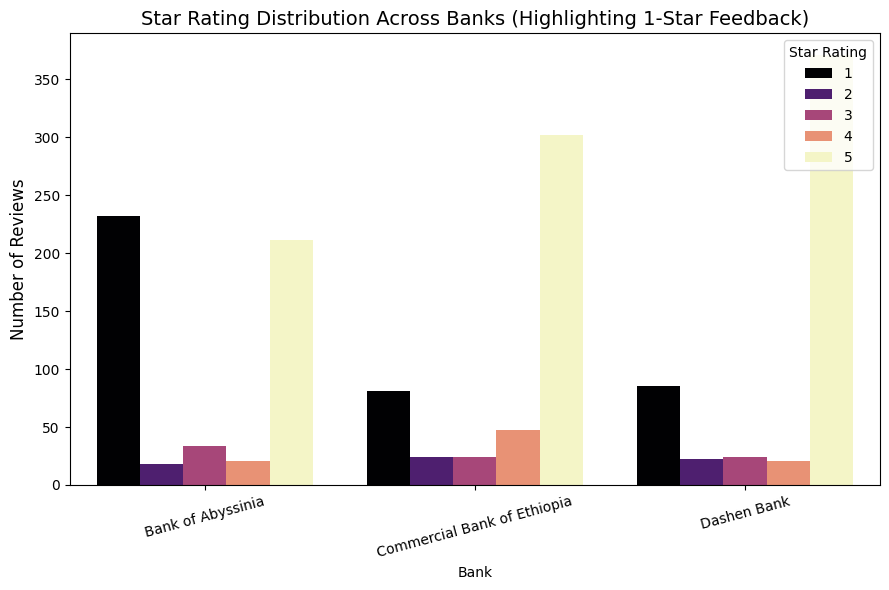

✓ Chart saved to: reports/visuals\02_rating_distribution_chart.png


In [9]:
# --- CELL 10: Rating Distribution Chart (Report Insight 3) ---

if not df.empty:
    plt.figure(figsize=(9, 6))

    # Calculate the count of each rating (1-5) for each bank
    rating_counts = df.groupby(['bank', 'rating']).size().reset_index(name='count')
    
    # Create the grouped bar plot
    ax = sns.barplot(x='bank', y='count', hue='rating', data=rating_counts, palette='magma', dodge=True)

    plt.title('Star Rating Distribution Across Banks (Highlighting 1-Star Feedback)', fontsize=14)
    plt.xlabel('Bank')
    plt.ylabel('Number of Reviews', fontsize=12)
    plt.legend(title='Star Rating', loc='upper right')
    plt.xticks(rotation=15)
    plt.tight_layout()

    # Save the figure
    filename = os.path.join(OUTPUT_DIR, '02_rating_distribution_chart.png')
    plt.savefig(filename)
    plt.show()
    print(f"✓ Chart saved to: {filename}")

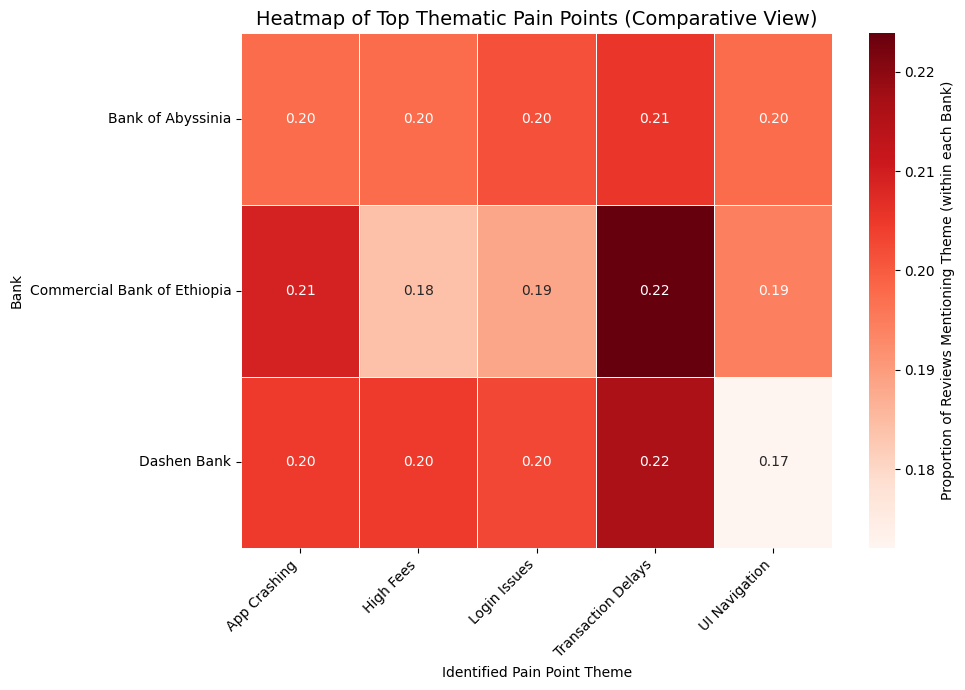

✓ Chart saved to: reports/visuals\03_thematic_heatmap.png


In [10]:
# --- CELL 11: Thematic Pain Points Heatmap (Report Insight 4) ---

if not df.empty and 'thematic_pain_point' in df.columns:
    plt.figure(figsize=(10, 7))
    
    # Select the top 5 most common themes for a clear heatmap
    top_themes = df['thematic_pain_point'].value_counts().head(5).index.tolist()
    df_themes = df[df['thematic_pain_point'].isin(top_themes)]

    # Aggregate the count of reviews for each Bank x Theme combination
    theme_matrix = df_themes.groupby(['bank', 'thematic_pain_point']).size().unstack(fill_value=0)

    # Normalize by the row sum (total reviews for that bank) to show proportion
    theme_matrix_normalized = theme_matrix.div(theme_matrix.sum(axis=1), axis=0)

    # Create the heatmap
    sns.heatmap(
        theme_matrix_normalized,
        annot=True,              # Show the actual value in each cell
        fmt=".2f",               # Format to 2 decimal places (shows proportion)
        cmap="Reds",             # Use a red color map to highlight pain points
        linewidths=.5,           # Add lines between cells
        cbar_kws={'label': 'Proportion of Reviews Mentioning Theme (within each Bank)'}
    )

    plt.title('Heatmap of Top Thematic Pain Points (Comparative View)', fontsize=14)
    plt.ylabel('Bank')
    plt.xlabel('Identified Pain Point Theme')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Save the figure
    filename = os.path.join(OUTPUT_DIR, '03_thematic_heatmap.png')
    plt.savefig(filename)
    plt.show()
    print(f"✓ Chart saved to: {filename}")